## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import pickle
from mlxtend.data import loadlocal_mnist

## Setting Numpy Seed

In [2]:
np.random.seed(10)

## Processing MNIST Dataset

In [3]:
def process_mnist_data() -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    mnist_path = './MNIST/'
    train_images, train_labels = loadlocal_mnist(
        images_path = mnist_path + './train-images.idx3-ubyte',
        labels_path = mnist_path + './train-labels.idx1-ubyte'
    )
    test_images, test_labels = loadlocal_mnist(
        images_path = mnist_path + './t10k-images.idx3-ubyte',
        labels_path = mnist_path + './t10k-labels.idx1-ubyte'
    )
    return train_images, train_labels, test_images, test_labels

## Processing CIFAR-10 Dataset

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

In [5]:
def process_cifar_dataset() -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    cifar_path = './cifar-10-python/cifar-10-batches-py'
    data_batch = unpickle(cifar_path + '/data_batch_1')
    train_images, train_labels = data_batch[b'data'], np.array(data_batch[b'labels'])
    for i in range(2,6):
        data_batch = unpickle(cifar_path + '/data_batch_' + str(i))
        train_images = np.concatenate((train_images, data_batch[b'data']), axis=0)
        train_labels = np.concatenate((train_labels, np.array(data_batch[b'labels'])), axis=0)
    test_batch = unpickle(cifar_path + '/test_batch')
    test_images, test_labels = test_batch[b'data'], np.array(test_batch[b'labels'])
    return train_images, train_labels, test_images, test_labels

## Processing Toy Dataset

In [6]:
def process_toy_dataset():
    toy_dataset_path = './Toy Dataset/'
    a = np.loadtxt(toy_dataset_path + 'trainNN.txt')
    b = np.loadtxt(toy_dataset_path + 'testNN.txt')
    train_x, train_y, test_x, test_y = a[:, 0:4], a[:, -1], b[:, 0:4], b[:, -1]
    return train_x, train_y, test_x, test_y

In [7]:
x_train_toy, y_train_toy, x_test_toy, y_test_toy = process_toy_dataset()
toy_batch_1 = x_train_toy[0:50].reshape(50, 1, 2, 2)
toy_batch_1[0, 0, :, :]

array([[ 9.21323266, 11.82445528],
       [16.69098092, 19.56967227]])

In [8]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(1,5))
toy_labels_1 = label_binarizer.transform(y_train_toy[0:50].T)
toy_labels_1

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1,

## Parsing Input Model

In [9]:
def parse_input_model():
    path = './input_model.txt'
    model = []
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            tokens = line.split()
            if tokens[0] == 'Conv':
                model.append(ConvolutionLayer(int(tokens[1]), int(tokens[2]), int(tokens[3]), int(tokens[4])))
            if tokens[0] == 'ReLU':
                model.append(ActivationLayer())
            if tokens[0] == 'Pool':
                model.append(MaxPoolingLayer(int(tokens[1]), int(tokens[2])))
            if tokens[0] == 'FC':
                model.append(FlatteningLayer())
                model.append(FullyConnectedLayer(int(tokens[1])))
            if tokens[0] == 'Softmax':
                model.append(SoftmaxLayer())
        return model

## ReLU Function

In [10]:
def relu(matrix:np.ndarray) -> np.ndarray:
    return matrix * (matrix > 0)

## Convolution Layer

In [11]:
class ConvolutionLayer:
    def __init__(self, output_channel_count: int, filter_dimension: int, stride: int, padding: int):
        self.output_channel_count = output_channel_count
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.padding = padding

    def forward(self, input_image: np.ndarray) -> np.ndarray:
        input_dimentions = input_image.shape[0]
        output_dimentions = (input_dimentions - self.filter_dimension + 2 * self.padding) // self.stride + 1
        input_shape = input_image.shape

        filters = np.random.rand(
            self.output_channel_count,
            self.filter_dimension,
            self.filter_dimension,
            input_shape[2]
        )

        bias = np.random.rand(self.output_channel_count)

        padded_image = np.pad(input_image, [(self.padding,self.padding), (self.padding,self.padding), (0,0)], mode='constant') * 1.0
        padded_image /= 255.0
        padded_dimensions = padded_image.shape

        output = np.zeros((output_dimentions, output_dimentions, self.output_channel_count))

        image_y = out_y = 0
        while image_y + self.filter_dimension <= padded_dimensions[1]:
            image_x = out_x = 0
            while image_x + self.filter_dimension <= padded_dimensions[0]:
                image_slice = padded_image[image_x:image_x+self.filter_dimension, image_y:image_y+self.filter_dimension, :]
                output[out_x, out_y, :] = np.sum(image_slice * filters) + bias
                image_x += self.stride
                out_x += 1
            image_y += self.stride
            out_y += 1

        return output

    def backward(self):
        pass

In [12]:
class ConvolutionLayerBatch:
    def __init__(self, output_channel_count: int, filter_dimension: int, stride: int, padding: int):
        self.output_channel_count = output_channel_count
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.padding = padding

    def forward(self, input_batch: np.ndarray) -> np.ndarray:
        input_dimentions = input_batch.shape
        output_dimentions = (input_dimentions[2] - self.filter_dimension + 2 * self.padding) // self.stride + 1
        input_shape = input_batch.shape

        filters = np.random.rand(
            self.output_channel_count,
            input_shape[1],
            self.filter_dimension,
            self.filter_dimension
        )

        bias = np.random.rand(self.output_channel_count)

        padded_image = np.pad(input_batch, [(0, 0), (0, 0), (self.padding,self.padding), (self.padding,self.padding)], mode='constant') * 1.0
        padded_image /= 255.0
        padded_dimensions = padded_image.shape

        output = np.zeros((input_dimentions[0], self.output_channel_count, output_dimentions, output_dimentions))

        for i in range(input_dimentions[0]):
            image_y = out_y = 0
            while image_y + self.filter_dimension <= padded_dimensions[3]:
                image_x = out_x = 0
                while image_x + self.filter_dimension <= padded_dimensions[2]:
                    image_slice = padded_image[i, :, image_x:image_x+self.filter_dimension, image_y:image_y+self.filter_dimension]
                    output[i, :, out_x, out_y] = np.sum(image_slice * filters) + bias
                    image_x += self.stride
                    out_x += 1
                image_y += self.stride
                out_y += 1

        return output

    def backward(self):
        pass

In [13]:
test_conv = ConvolutionLayerBatch(4, 2, 2, 2)
test_conv_out = test_conv.forward(toy_batch_1)
test_conv_out.shape

(50, 4, 3, 3)

In [14]:
test_conv_out[0, 0, :, :]

array([[0.72175532, 0.72175532, 0.72175532],
       [0.72175532, 1.20161669, 0.72175532],
       [0.72175532, 0.72175532, 0.72175532]])

## Activation Layer

In [15]:
class ActivationLayer:
    def __init__(self):
        pass

    def forward(self, input_matrix: np.ndarray) -> np.ndarray:
        return relu(input_matrix)

    def backward(self):
        pass

In [16]:
test_activation = ActivationLayer()
test_activation_out = test_activation.forward(test_conv_out)
test_activation_out.shape

(50, 4, 3, 3)

In [17]:
test_activation_out[0, 0, :, :]

array([[0.72175532, 0.72175532, 0.72175532],
       [0.72175532, 1.20161669, 0.72175532],
       [0.72175532, 0.72175532, 0.72175532]])

## Max Pooling Layer

In [18]:
class MaxPoolingLayer:
    def __init__(self, filter_dimension: int, stride: int):
        self.filter_dimension = filter_dimension
        self.stride = stride

    def forward(self, image: np.ndarray) -> np.ndarray:
        input_dimensions = image.shape
        output_dimension = (input_dimensions[0] - self.filter_dimension) // self.stride + 1

        output = np.zeros((output_dimension, output_dimension, input_dimensions[2]))

        image_y = out_y = 0
        while image_y + self.filter_dimension <= input_dimensions[1]:
            image_x = out_x = 0
            while image_x + self.filter_dimension <= input_dimensions[0]:
                image_slice = image[image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension, :]
                output[out_x, out_y, :] = np.max(image_slice, axis=(0, 1))
                image_x += self.stride
                out_x += 1
            image_y += self.stride
            out_y += 1

        return output

    def backward(self):
        pass

In [19]:
class MaxPoolingLayerBatch:
    def __init__(self, filter_dimension: int, stride: int):
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.index_tracker = None

    def forward(self, image: np.ndarray) -> np.ndarray:
        input_dimensions = image.shape
        output_dimension = (input_dimensions[2] - self.filter_dimension) // self.stride + 1

        output = np.zeros((input_dimensions[0], input_dimensions[1], output_dimension, output_dimension))
        if not self.index_tracker:
            self.index_tracker = np.zeros((input_dimensions[0], input_dimensions[1], output_dimension, output_dimension))

        for i in range(input_dimensions[0]):
            image_y = out_y = 0
            while image_y + self.filter_dimension <= input_dimensions[3]:
                image_x = out_x = 0
                while image_x + self.filter_dimension <= input_dimensions[2]:
                    image_slice = image[i, :, image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension]
                    output[i, :, out_x, out_y] = np.max(image_slice, axis=(1, 2))
                    # self.index_tracker[i, out_x, out_y, :] = np.argmax(image[i, image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension, :], axis=(0, 1))
                    image_x += self.stride
                    out_x += 1
                image_y += self.stride
                out_y += 1

        return output

    def backward(self):
        pass

In [20]:
test_maxpool = MaxPoolingLayerBatch(2, 1)
test_maxpool_out = test_maxpool.forward(test_activation_out)
test_maxpool_out.shape

(50, 4, 2, 2)

In [21]:
test_maxpool_out[0, 0, :, :]

array([[1.20161669, 1.20161669],
       [1.20161669, 1.20161669]])

## Flattening Layer

In [22]:
class FlatteningLayer:
    def __init__(self):
        pass

    def forward(self, image: np.ndarray) -> np.ndarray:
        return image.flatten().reshape(-1, 1)

    def backward(self):
        pass

In [23]:
class FlatteningLayerBatch:
    def __init__(self):
        self.input_shape = None

    def forward(self, input_batch: np.ndarray) -> np.ndarray:
        input_shape = input_batch.shape
        self.input_shape = input_shape
        return input_batch.reshape((input_shape[0], -1))

    def backward(self, dh_flattened: np.ndarray) -> np.ndarray:
        return dh_flattened.reshape(self.input_shape)

In [24]:
test_flattening = FlatteningLayerBatch()
test_flattening_out = test_flattening.forward(test_maxpool_out)
test_flattening_out.shape

(50, 16)

In [25]:
test_flattening_out

array([[1.20161669, 1.20161669, 1.20161669, 1.20161669, 0.77173744,
        0.77173744, 0.77173744, 0.77173744, 1.3976355 , 1.3976355 ,
        1.3976355 , 1.3976355 , 1.19443716, 1.19443716, 1.19443716,
        1.19443716],
       [1.66545862, 1.66545862, 1.66545862, 1.66545862, 1.23557937,
        1.23557937, 1.23557937, 1.23557937, 1.86147742, 1.86147742,
        1.86147742, 1.86147742, 1.65827908, 1.65827908, 1.65827908,
        1.65827908],
       [2.60606404, 2.60606404, 2.60606404, 2.60606404, 2.17618479,
        2.17618479, 2.17618479, 2.17618479, 2.80208285, 2.80208285,
        2.80208285, 2.80208285, 2.59888451, 2.59888451, 2.59888451,
        2.59888451],
       [2.13730758, 2.13730758, 2.13730758, 2.13730758, 1.70742833,
        1.70742833, 1.70742833, 1.70742833, 2.33332639, 2.33332639,
        2.33332639, 2.33332639, 2.13012805, 2.13012805, 2.13012805,
        2.13012805],
       [2.60564651, 2.60564651, 2.60564651, 2.60564651, 2.17576727,
        2.17576727, 2.17576727, 

## Fully Connected Layer

In [26]:
class FullyConnectedLayer:
    def __init__(self, output_dimension: int):
        self.output_dimension = output_dimension

    def forward(self, flattened_input: np.ndarray) -> np.ndarray:
        weights = np.random.rand(flattened_input.shape[0], self.output_dimension)
        bias = np.random.rand(self.output_dimension, 1)

        return weights.T @ flattened_input + bias

    def backward(self):
        pass

In [27]:
class FullyConnectedLayerBatch:
    def __init__(self, output_dimension: int):
        self.output_dimension = output_dimension
        self.input_matrix = None
        self.weights = None
        self.bias = None

    def forward(self, flattened_input: np.ndarray) -> np.ndarray:
        if not self.weights:
            self.weights = np.random.rand(flattened_input.shape[1], self.output_dimension)
        if not self.bias:
            self.bias = np.random.rand(1, self.output_dimension)
        self.input_matrix = flattened_input

        return flattened_input @ self.weights + self.bias

    def backward(self, d_theta: np.ndarray, learning_rate: int) -> np.ndarray:
        n = d_theta.shape[0]
        dw = self.input_matrix.T @ d_theta
        db = np.sum(d_theta, axis=0, keepdims=True)
        dh = d_theta @ self.weights.T
        self.weights = self.weights - learning_rate * dw / n
        self.bias = self.bias - learning_rate * db / n

        return dh

In [28]:
test_fc = FullyConnectedLayerBatch(4)
test_fc_out = test_fc.forward(test_flattening_out)
test_fc_out.shape

(50, 4)

In [29]:
test_fc_out

array([[10.35351109,  9.62463702,  8.06550849,  8.8549909 ],
       [14.27700238, 13.62230028, 11.08408648, 12.43295797],
       [22.23328444, 21.72899254, 17.20533315, 19.68856609],
       [18.26822266, 17.68897292, 14.15477247, 16.07268945],
       [22.22975271, 21.72539405, 17.20261597, 19.68534538],
       [14.21600823, 13.56015306, 11.03716001, 12.3773353 ],
       [10.23151135,  9.50033093,  7.97164675,  8.74373513],
       [18.32579054, 17.7476291 , 14.19906291, 16.12518759],
       [10.2635961 ,  9.53302223,  7.99633148,  8.77299432],
       [18.27564643, 17.69653703, 14.16048402, 16.07945944],
       [18.21597454, 17.63573707, 14.11457485, 16.02504259],
       [18.29703892, 17.71833394, 14.17694255, 16.09896799],
       [18.31369452, 17.73530441, 14.18975671, 16.11415681],
       [14.16346055, 13.50661199, 10.99673192, 12.32941526],
       [10.17186372,  9.43955568,  7.92575623,  8.6893404 ],
       [14.25150001, 13.5963158 , 11.06446598, 12.40970149],
       [10.29525579,  9.

## Softmax Layer

In [30]:
class SoftmaxLayer:
    def __init__(self):
        pass

    def forward(self, input_matrix: np.ndarray) -> np.ndarray:
        exp = np.exp(input_matrix)
        exp /= np.sum(exp)
        return exp

    def backward(self):
        pass

In [31]:
class SoftmaxLayerBatch:
    def __init__(self):
        self.y_hat = None

    def forward(self, input_matrix: np.ndarray) -> np.ndarray:
        exp = np.exp(input_matrix)
        exp_sum = np.sum(exp, axis=1).reshape(-1, 1)
        exp /= exp_sum
        self.y_hat = exp
        return exp

    def backward(self, y: np.ndarray) -> np.ndarray:
        return self.y_hat - y

In [32]:
test_softmax = SoftmaxLayerBatch()
test_softmax_out = test_softmax.forward(test_fc_out)
test_softmax_out.shape

(50, 4)

In [33]:
test_softmax_out

array([[0.55328664, 0.26693419, 0.05614141, 0.12363776],
       [0.58179272, 0.30229765, 0.02388375, 0.09202588],
       [0.59207317, 0.35757256, 0.00387939, 0.04647488],
       [0.59242792, 0.33194838, 0.00968694, 0.06593675],
       [0.59207687, 0.35755093, 0.00388258, 0.04648962],
       [0.58151032, 0.30180271, 0.02421036, 0.09247661],
       [0.55200449, 0.2657021 , 0.05760974, 0.12468368],
       [0.59248702, 0.33234299, 0.00956013, 0.06560986],
       [0.55234436, 0.266027  , 0.05722021, 0.12440843],
       [0.59243567, 0.33199931, 0.0096705 , 0.06589452],
       [0.59237235, 0.33158956, 0.00980346, 0.06623463],
       [0.59245778, 0.332146  , 0.00962326, 0.06577295],
       [0.59247479, 0.33226014, 0.00958664, 0.06567843],
       [0.58126358, 0.30137513, 0.02449516, 0.09286613],
       [0.55136752, 0.2650964 , 0.05834036, 0.12519572],
       [0.58167516, 0.30209089, 0.02401979, 0.09221415],
       [0.55267786, 0.26634699, 0.0568382 , 0.12413695],
       [0.59250536, 0.33246836,

## Backprop Test

#### Loss Function

In [34]:
def loss_function(y_true, y_pred):
    labels = y_true * np.log(y_pred) * -1.0
    return np.sum(labels) / y_true.shape[0]

In [35]:
loss_function_test = loss_function(toy_labels_1, test_softmax_out)
loss_function_test

2.4556159699350304

#### Softmax Layer

In [36]:
test_softmax_back = test_softmax.backward(toy_labels_1)
print(test_softmax_back.shape)
test_softmax_back

(50, 4)


array([[-0.44671336,  0.26693419,  0.05614141,  0.12363776],
       [ 0.58179272, -0.69770235,  0.02388375,  0.09202588],
       [ 0.59207317,  0.35757256,  0.00387939, -0.95352512],
       [ 0.59242792,  0.33194838, -0.99031306,  0.06593675],
       [ 0.59207687,  0.35755093,  0.00388258, -0.95351038],
       [ 0.58151032, -0.69819729,  0.02421036,  0.09247661],
       [-0.44799551,  0.2657021 ,  0.05760974,  0.12468368],
       [ 0.59248702,  0.33234299, -0.99043987,  0.06560986],
       [-0.44765564,  0.266027  ,  0.05722021,  0.12440843],
       [ 0.59243567,  0.33199931, -0.9903295 ,  0.06589452],
       [ 0.59237235,  0.33158956, -0.99019654,  0.06623463],
       [ 0.59245778,  0.332146  , -0.99037674,  0.06577295],
       [ 0.59247479,  0.33226014, -0.99041336,  0.06567843],
       [ 0.58126358, -0.69862487,  0.02449516,  0.09286613],
       [-0.44863248,  0.2650964 ,  0.05834036,  0.12519572],
       [ 0.58167516, -0.69790911,  0.02401979,  0.09221415],
       [-0.44732214,  0.

#### Fully Connected Layer

In [37]:
test_fc_back = test_fc.backward(test_softmax_back, learning_rate=0.01)
print(test_fc_back.shape)
test_fc_back

(50, 16)


array([[-0.10010352,  0.01660596, -0.02040161, -0.27843417,  0.25035061,
         0.09118991,  0.17025697, -0.06776964, -0.18814022, -0.24192317,
         0.07712478,  0.1200323 ,  0.11416985,  0.05399208, -0.08841738,
        -0.06747464],
       [ 0.2874105 ,  0.01621933,  0.02628684,  0.33574623, -0.45310295,
        -0.16943281, -0.23351681,  0.09222417,  0.46832469,  0.29909239,
        -0.21528032, -0.19634103, -0.30701436, -0.24862106,  0.03880738,
         0.03248295],
       [-0.26929293, -0.07010458,  0.10571787,  0.36576255, -0.23319781,
        -0.19909087, -0.36366209,  0.16413782, -0.35868374,  0.51142183,
         0.11581752, -0.13997878,  0.06313395,  0.37430073,  0.39918908,
         0.29443783],
       [ 0.0433375 , -0.17212348, -0.17819997,  0.57452298,  0.33746025,
         0.4558439 ,  0.22402208, -0.13494542,  0.21848852, -0.06497898,
         0.16312943,  0.08313667,  0.44154626,  0.05770327, -0.06741858,
        -0.04555032],
       [-0.26928287, -0.0701028 ,  0

#### Flattening Layer

In [38]:
test_flattening_back = test_flattening.backward(test_fc_back)
test_flattening_back[0, 0, :, :]

array([[-0.10010352,  0.01660596],
       [-0.02040161, -0.27843417]])

## Main Test

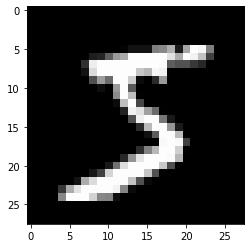

In [39]:
x_train, y_train, x_test, y_test = process_mnist_data()
img = x_train[0].reshape(28, 28, 1)
plt.imshow(img, cmap='gray')

In [40]:
m = parse_input_model()
c1 = ConvolutionLayerBatch(6, 5, 1, 2)
mnist_batch_1 = x_train[0:64].reshape(64, 28, 28, 1)
o = c1.forward(mnist_batch_1)
print(o.shape)

(64, 6, 28, 28)


In [41]:
o[0, :, :, 0]

array([[5.13991021e-01, 5.13991021e-01, 2.34726495e+00, 6.22690095e+00,
        1.12072901e+01, 1.88108206e+01, 3.38048208e+01, 4.77333037e+01,
        6.16420428e+01, 7.92249902e+01, 1.01786992e+02, 1.21545266e+02,
        1.28731697e+02, 1.37192884e+02, 1.41634120e+02, 1.42932379e+02,
        1.29960855e+02, 1.16581002e+02, 9.55354550e+01, 7.46750801e+01,
        5.01304588e+01, 3.25171184e+01, 2.02950790e+01, 1.41210649e+01,
        8.04039959e+00, 2.75846706e+00, 5.13991021e-01, 5.13991021e-01],
       [4.87361328e-02, 4.87361328e-02, 1.88201006e+00, 5.76164606e+00,
        1.07420352e+01, 1.83455657e+01, 3.33395659e+01, 4.72680488e+01,
        6.11767879e+01, 7.87597353e+01, 1.01321737e+02, 1.21080011e+02,
        1.28266442e+02, 1.36727629e+02, 1.41168866e+02, 1.42467124e+02,
        1.29495600e+02, 1.16115747e+02, 9.50702001e+01, 7.42098252e+01,
        4.96652039e+01, 3.20518635e+01, 1.98298241e+01, 1.36558100e+01,
        7.57514470e+00, 2.29321217e+00, 4.87361328e-02, 4.87361

In [42]:
a1 = ActivationLayer()
o1 = a1.forward(o)
o1.shape

(64, 6, 28, 28)

In [43]:
m1 = MaxPoolingLayerBatch(2, 2)
o2 = m1.forward(o1)
o2.shape

(64, 6, 14, 14)

In [44]:
x = np.arange(1,25).reshape(2, 3, 4)
x

array([[[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]],

       [[13, 14, 15, 16],
        [17, 18, 19, 20],
        [21, 22, 23, 24]]])

In [45]:
y = np.max(x, axis=(1, 2))
y

array([12, 24])